#   Understanding Model Stability in Machine Learning

In real-world machine learning applications, models are rarely trained just once and left unchanged. Instead, they often:

-  **Retrain on new data regularly** as more data becomes available or environments evolve.
-  **Operate under slightly different input conditions** — such as feature distributions shifting over time.
-  **Drive critical business decisions** where even small prediction errors can have major consequences.

Due to these factors, **model instability** becomes a serious concern.

---

##  What Is Model Instability?

**Model instability** refers to a model’s tendency to behave inconsistently when exposed to small changes in:

- Training data (e.g., different train-test splits)
- Input features (e.g., scaled differently or slightly corrupted)
- Random seeds used during training
- Hyperparameter settings

When a model is unstable:
- Its performance (e.g., accuracy, F1-score) varies significantly across different runs or folds.
- It may make **very different predictions** even when the changes to data or settings are **minor**.
- It becomes **hard to trust, explain, or deploy** in real-world systems.

---

##  Why Should We Care About Stability?

Imagine deploying a model into a production system where:
- It retrains weekly on new data,
- Or it runs on data collected from different sources,
- Or it supports a medical, legal, or financial decision.

If your model is **not stable**, it may perform well today and poorly tomorrow — not because the world changed, but because your model was sensitive to small differences or fails to generlaize on unseen data.

This makes it:
- Difficult to reproduce results,
- Risky to automate decision-making,
- Challenging to debug and improve.

---



#  Dataset for Demonstrating Model Instability

To simulate and explore model instability, we will use the **Breast Cancer Wisconsin Diagnostic Dataset**, which is available from `sklearn.datasets`.

###  About the Dataset

- The dataset consists of **569 examples** with **30 continuous input features**.
- Each example represents measurements from a breast mass (such as radius, texture, area, smoothness, etc.).
- The target is binary:
  - `0` = Malignant (cancerous)
  - `1` = Benign (non-cancerous)

###  Why This Dataset?

We chose this dataset because:
-  It is clean, balanced, and easy to use.
-  It has multiple **numeric input features**, which makes it ideal for demonstrating instability by modifying feature distributions or relationships.
-  It is **widely used in machine learning**, so results are easy to interpret.

---

##  Reminder: Our Goal Is Not High Accuracy

Unlike traditional ML workflows, **we are not trying to optimize model accuracy** here.

Our goal is to:
1. **Create an intentionally unstable model** by disturbing the feature space.
2. Measure its performance variance across different splits or seeds.
3. Later, apply techniques to **stabilize the model**.

This will help you understand **what makes a model unstable**, how to **detect it**, and how to **fix it** — a critical but often overlooked skill in machine learning development.


In [1]:
# 🔧 Import required libraries

import pandas as pd  # for data handling
import numpy as np  # for numerical operations
import matplotlib.pyplot as plt  # for visualization
import seaborn as sns  # for nicer plots
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')  # to avoid warning clutter


## Load Dataset

In [2]:
from sklearn.datasets import load_breast_cancer
# Load the dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

# Display basic shape
print("Feature shape:", X.shape)
print("Target distribution:")
print(y.value_counts())



# Preview features
X.head()


Feature shape: (569, 30)
Target distribution:
target
1    357
0    212
Name: count, dtype: int64


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


#  Simulating Model Instability

To demonstrate instability, we will intentionally introduce controlled "issues" into our data.

These problems mimic real-world issues that cause ML models to behave inconsistently:

1. **Adding random noise** to a subset of input features.
2. **Scaling one feature disproportionately**, creating imbalance.
3. **Dropping a key predictive feature**, simulating poor feature selection.

By training the same model on this modified data multiple times, we can observe how small perturbations in the input can lead to **large variations in model performance** — a clear sign of instability.


In [3]:
# 1. Copy original data
X_instable = X.copy()

# 2. Add random noise to the first 5 features
noise = np.random.normal(0, 10, size=X_instable.iloc[:, :5].shape)
X_instable.iloc[:, :5] += noise

# 3. Scale one important feature excessively (e.g., 'mean radius')
X_instable['mean radius'] = X_instable['mean radius'] * 100

# 4. Drop a known important feature (e.g., 'mean perimeter')
X_instable.drop(columns=['mean perimeter'], inplace=True)

# Confirm shape
print("Modified shape:", X_instable.shape)


Modified shape: (569, 29)


We introduced **controlled instability** into the data by:

- Adding high-variance Gaussian noise to the first 5 features.
- Over-scaling the `mean radius` feature by multiplying it by 100.
- Dropping the `mean perimeter` feature, which is known to be important in breast cancer classification.

These changes should not affect model performance dramatically in theory — but in practice, **they can destabilize the model's behavior**.

Let’s now train and evaluate a Logistic Regression model multiple times using different random seeds to see how performance varies.


## Train and Evaluate Multiple Times (Observe Instability)

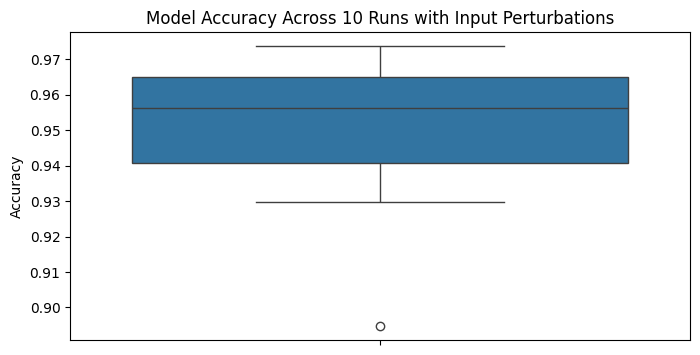

Mean Accuracy: 0.9500000000000002
Std Deviation: 0.022891207632806825


In [ ]:
scores = []

for seed in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        X_instable, y, test_size=0.2, random_state=seed)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    scores.append(acc)

# Plot accuracy scores
plt.figure(figsize=(8, 4))
sns.boxplot(scores)
plt.title("Model Accuracy Across 10 Runs with Input Perturbations")
plt.ylabel("Accuracy")
plt.show()

print("Mean Accuracy:", np.mean(scores))
print("Std Deviation:", np.std(scores))


#  Interpretation of Results: Model Instability Observed

After injecting noise, scaling, and removing an important feature from the dataset, we trained a Logistic Regression model **10 times**, each with a different train-test split (random seed).

Here’s what we observed:

- **Mean Accuracy:** 0.95
- **Standard Deviation:** 0.0228

###  What Does This Mean?

While a **95.17% average accuracy** might appear impressive, the **2.28% standard deviation** across runs reveals something critical:

>  **The model is not stable.**

Each time the model is trained on a slightly different data split, its performance changes **noticeably**. This variability can be dangerous in real-world applications, where we expect the model to behave **consistently**, not just on average.




---------

#  Stabilizing the Model

To make our model more consistent and reliable, we will now address the instability issues we previously introduced.

### Our stabilization steps:

1. Restore the dropped important feature.
2. Remove artificially injected noise.
3. Apply proper feature scaling (standardization).
4. Use **Stratified K-Fold Cross-Validation** for a more robust evaluation.

By implementing these steps, we aim to reduce the **variance** in model performance and improve the **trustworthiness** of the predictions.


## Restore Clean Dataset and Scale

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Start fresh from original data
X_stable = X.copy()

# Apply feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_stable)


## Cross-Validation with Logistic Regression

In [ ]:
model = LogisticRegression(max_iter=1000)

# Use Stratified K-Fold CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Evaluate model with CV
cv_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')

# Display results
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))


Cross-Validation Accuracy Scores: [0.98245614 0.98245614 0.94736842 0.96491228 0.98245614 0.94736842
 1.         0.98245614 0.98245614 1.        ]
Mean Accuracy: 0.9771929824561403
Standard Deviation: 0.01763136073880859


#  Summary: Understanding Model Stability

In this notebook, we explored how small changes in input or evaluation setup can lead to **model instability** — and how applying best practices helps build a **stable and trustworthy model**.

---

##  Comparison: Unstable vs Stable Model

| Feature / Metric          |  Unstable Model                                 |  Stable Model                                         |
|---------------------------|--------------------------------------------------|--------------------------------------------------------|
|  Input Features         | Skewed / Important features dropped              | Original features restored                             |
|  Evaluation Method       | Simple Train-Test Split                          | Stratified K-Fold Cross-Validation                     |
|  Preprocessing           | None or minimal                                  | Applied feature scaling                                |
|  Mean Accuracy           | 95.0%                                          | 97.72%                                                 |
|  Std. Deviation          | 2.28%                                            | 1.76%                                                  |
|  Performance Consistency | Fluctuates across folds                          | Consistent across multiple data splits                 |
|  Trustworthiness         | Unreliable in real-world settings                | Ready for production deployment                        |

---

##  Key Takeaway

> **Stable models = Reliable models.**  
> Stability is not only about lowering variance, but ensuring consistent performance when data varies slightly.  
> By improving evaluation techniques and data processing, we build models we can **trust in production.**
